In [60]:
import pandas as pd
import folium
from sklearn.cluster import KMeans
from hdbscan import HDBSCAN
import umap
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

sys.path.append(os.path.abspath('..')) 

from utils.preproc_utils import *
from utils.plot_utils import *
from utils.modeling_utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
sys.path.append(os.path.abspath('..')) 
base_dir = os.path.abspath(os.path.join(os.getcwd(), '../../data/processed/'))

preproc_path = os.path.join(base_dir, 'customer_info_preproc.csv')
customer_info_preproc = pd.read_csv(preproc_path, index_col='customer_id')

preproc_path_outliers = os.path.join(base_dir, 'customer_info_preproc_outliers.csv')
customer_info_preproc_outliers = pd.read_csv(preproc_path_outliers, index_col='customer_id')

combined_data = pd.concat([customer_info_preproc, customer_info_preproc_outliers])

### **Clustering Without Outliers**

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


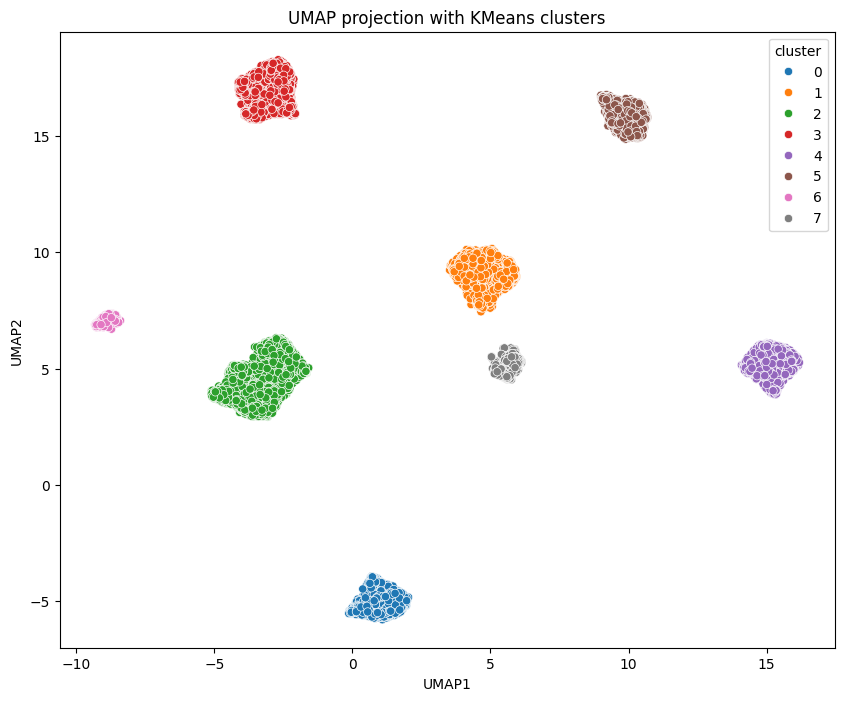

In [57]:
umap_reducer = umap.UMAP(n_neighbors=35, min_dist=0.0, n_components=2, random_state=42)
umap_embeddings_combined = umap_reducer.fit_transform(combined_data)

# split UMAP embeddings back into inliers and outliers
umap_embeddings = umap_embeddings_combined[:len(customer_info_preproc)]
umap_embeddings_outliers = umap_embeddings_combined[len(customer_info_preproc):]

# perform KMeans clustering on inliers
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans_labels = kmeans.fit_predict(umap_embeddings)

umap_df = pd.DataFrame(umap_embeddings, columns=['UMAP1', 'UMAP2'], index=customer_info_preproc.index)
umap_df['cluster'] = kmeans_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='cluster', data=umap_df, palette='tab10')
plt.title('UMAP projection with KMeans clusters')
plt.show()

### **Appending Outliers to the Existent Clusters**

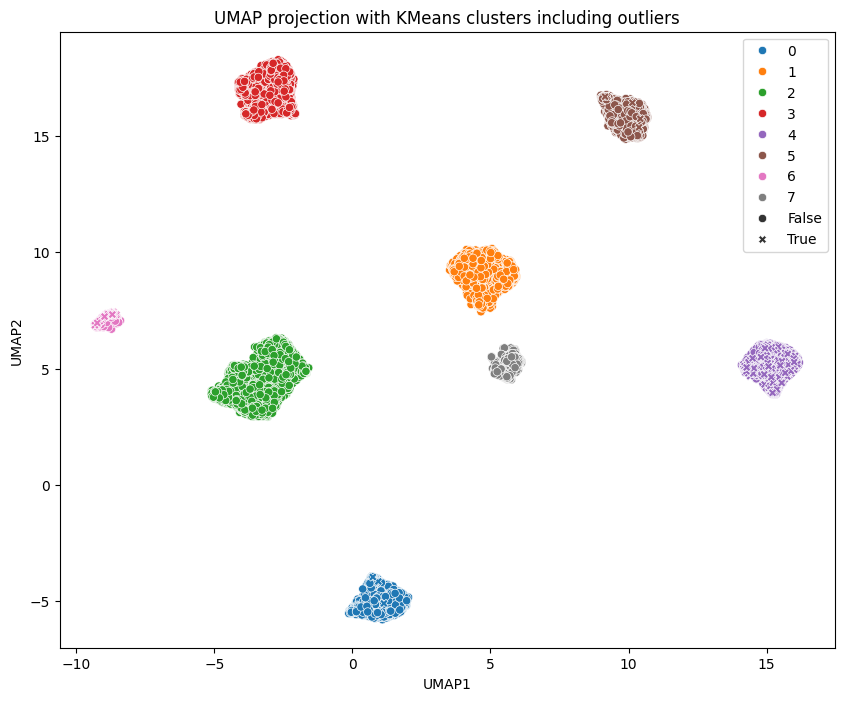

In [58]:
# k-Nearest Neighbors to classify outliers into existing clusters
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(umap_embeddings, kmeans_labels)

# predict clusters for outliers
outlier_clusters = knn.predict(umap_embeddings_outliers)

umap_df_outliers = pd.DataFrame(umap_embeddings_outliers, columns=['UMAP1', 'UMAP2'], index=customer_info_preproc_outliers.index)
umap_df_outliers['cluster'] = outlier_clusters

# combine the inliers and outliers for final visualization
final_umap_df = pd.concat([umap_df, umap_df_outliers])

plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='cluster', data=final_umap_df, palette='tab10', style=final_umap_df.index.isin(umap_df_outliers.index))
plt.title('UMAP projection with KMeans clusters including outliers')
plt.legend(loc='best')
plt.show()

### **Exporting the Clusters**

In [6]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), '../../data/raw/'))
customer_info = pd.read_csv(os.path.join(base_dir, 'customer_info.csv'), index_col='customer_id')
customer_info_clean = clean_customer_data(customer_info)

customer_info_clean_labeled = pd.merge(customer_info_clean, final_umap_df['cluster'], how='left', on='customer_id')

export_clusters(customer_info_clean_labeled, 'cluster')

/Users/cicerosantos/Documents/GitHub/MLII/src/utils/preproc_utils.py:57: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  new_df[birthdate_column] = pd.to_datetime(new_df[birthdate_column])


## **Visualizing the Clusters**

In [61]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), '../../data/clusters/'))
fishy_outliers = pd.read_csv(os.path.join(base_dir, 'fishy_outliers.csv'), index_col='customer_id')

In [62]:
customer_info_clean = clean_customer_to_cluster(customer_info)

/Users/cicerosantos/Documents/GitHub/MLII/src/utils/preproc_utils.py:169: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_copy['customer_birthdate'] = pd.to_datetime(df_copy['customer_birthdate'])


In [63]:
final_umap_df = add_fishy(final_umap_df, fishy_outliers)

In [72]:
clients_clusterizeds = pd.merge(customer_info_clean, final_umap_df['cluster'], how='left', on='customer_id')
clients_clusterizeds.head()

Unnamed: 0  customer_name customer_gender  kids_home  teens_home  \
customer_id                                                                     
39634                 0    David Frink            male        1.0         1.0   
43460                 1  Belinda Terry          female        1.0         0.0   
23937                 2  Evelyn Calico          female        0.0         1.0   
2431                  3    Ora Boggess          female        0.0         0.0   
10090                 4  Lonnie Hopson            male        0.0         0.0   

             number_complaints  distinct_stores_visited  typical_hour  \
customer_id                                                             
39634                      1.0                      2.0          17.0   
43460                      1.0                      2.0           8.0   
23937                      1.0                      3.0          10.0   
2431                       0.0                      1.0          17.0   
10090                      0.0                      1.0           NaN   

             lifetime_total_distinct_products  \
customer_id                                     
39634                                    32.0   
43460                                  2566.0   
23937                                  1282.0   
2431                                     70.0   
10090                                     4.0   

             percentage_of_products_bought_promotion  ...  \
customer_id                                           ...   
39634                                       0.072206  ...   
43460                                       0.206227  ...   
23937                                       0.136168  ...   
2431                                        0.215852  ...   
10090                                       0.181023  ...   

             percentage_nonalcohol_drinks  percentage_alcohol_drinks  \
customer_id                                                            
39634                            1.425907                   2.226209   
43460                            2.279515                   7.417566   
23937                            4.820368                   9.793494   
2431                             1.563178                   0.372185   
10090                            0.629651                  54.054570   

             percentage_meat  percentage_fish  percentage_hygiene  \
customer_id                                                         
39634               5.255082         9.575297            5.132321   
43460               6.509417        11.732797           12.890839   
23937               2.523338        13.278642            7.388967   
2431                1.767880         0.936666            0.328764   
10090               1.030338         3.281816           11.200153   

             percentage_videogames  percentage_petfood  percentage_groceries  \
customer_id                                                                    
39634                     9.315612            5.934984             43.216318   
43460                     6.265618           12.110684             30.566222   
23937                     8.509194           11.417256             17.521924   
2431                      0.000000           25.649774             67.148440   
10090                     4.254913            1.221141             13.298989   

             has_loyalty_card  cluster  
customer_id                             
39634                       0        4  
43460                       0        5  
23937                       1        5  
2431                        1        0  
10090                       1        6  

[5 rows x 27 columns]

In [73]:
# Count rows where 'cluster' is 8
num_rows = (clients_clusterizeds['cluster'] == 8).sum()

print(num_rows)

388


In [74]:
# Filter rows where 'cluster' is 8
cluster_8_rows = clients_clusterizeds[clients_clusterizeds['cluster'] == 8]

# Print first 10 rows
print(cluster_8_rows.head(10))

             Unnamed: 0    customer_name customer_gender  kids_home  \
customer_id                                                           
48086               160  Charles`s Fishy            male        0.0   
31838               202   Ursula`s Fishy          female        0.0   
41519               302  Lindsay`s Fishy          female        0.0   
41076               571    Carol`s Fishy          female        0.0   
43120               668  Rosetta`s Fishy          female        0.0   
3647                789   Hector`s Fishy            male        0.0   
29825               919     Kara`s Fishy          female        0.0   
637                1196   Dianne`s Fishy          female        0.0   
22356              1230     Juan`s Fishy            male        0.0   
25919              1413   Edison`s Fishy            male        0.0   

             teens_home  number_complaints  distinct_stores_visited  \
customer_id                                                           
48086

In [75]:
summary = create_cluster_summary(clients_clusterizeds)
summary.drop(columns=['Unnamed: 0'], inplace=True)

### Cluster information and caractarization

In [76]:
summary.T

cluster                                             0             1  \
customer_gender                                female        female   
kids_home                                         0.0      3.052662   
teens_home                                   0.011813      1.993783   
number_complaints                            0.505271      0.991994   
distinct_stores_visited                           1.0      1.122794   
typical_hour                                11.858968     17.578118   
lifetime_total_distinct_products            51.709502    513.391004   
percentage_of_products_bought_promotion      0.197791      0.198728   
latitude                                    38.748669     38.749634   
longitude                                   -9.173753     -9.155712   
age                                         54.789672     54.515369   
years_as_customer                           12.946475     12.882121   
monetary                                 21527.461448  13342.720248   
percentage_electronics                       0.784425     14.794515   
percentage_vegetables                          0.9832      3.793745   
percentage_nonalcohol_drinks                  2.45793      3.820099   
percentage_alcohol_drinks                    0.198237      2.287529   
percentage_meat                              0.996862      7.559427   
percentage_fish                              1.001404      7.605936   
percentage_hygiene                           0.389864      7.543354   
percentage_videogames                             0.0      7.546157   
percentage_petfood                          47.141347      7.567799   
percentage_groceries                        46.098541     37.791201   
has_loyalty_card                                    0             1   
cluster                                           0.0           1.0   

cluster                                            2            3  \
customer_gender                                 male       female   
kids_home                                   0.663117     1.003142   
teens_home                                  0.932446     0.418113   
number_complaints                           0.915089     0.511168   
distinct_stores_visited                     2.719445     1.162696   
typical_hour                               12.699741    13.726322   
lifetime_total_distinct_products          408.412389   201.953597   
percentage_of_products_bought_promotion      0.39946      0.20125   
latitude                                   38.747516    38.747931   
longitude                                  -9.157122    -9.156889   
age                                        54.817947    54.431876   
years_as_customer                          12.881001    12.909873   
monetary                                 5842.930207  6055.338928   
percentage_electronics                      5.019587     6.579931   
percentage_vegetables                        5.16291    16.502248   
percentage_nonalcohol_drinks                6.189828     5.006879   
percentage_alcohol_drinks                   6.689651     1.961339   
percentage_meat                              7.79558     0.028656   
percentage_fish                             8.913752     0.025706   
percentage_hygiene                          8.905448      8.28272   
percentage_videogames                       7.262009     3.378764   
percentage_petfood                         10.160588      8.39179   
percentage_groceries                        34.26979     50.17789   
has_loyalty_card                                   1            0   
cluster                                          2.0          3.0   

cluster                                            4             5  \
customer_gender                               female          male   
kids_home                                   1.001972      0.996126   
teens_home                                  0.996371      0.820772   
number_complaints                            0.50054      1.001844   
distinct

In [77]:
plot_cluster(clients_clusterizeds, 4)

In [79]:
karens = customer_info_clean[customer_info_clean['number_complaints'] > 3]
karens_idx = karens.index
karens_idx.shape

(126,)

In [80]:
cluster1 = final_umap_df[final_umap_df['cluster'] == 1]
cluster1.shape

(10836, 3)

In [81]:
# check if karens in cluster 1
karens_in_cluster1 = karens_idx.intersection(cluster1.index)
karens_in_cluster1.shape

(122,)

C:\Users\vic\AppData\Local\Temp\ipykernel_5440\2240809235.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_1_data['subcluster'] = ward_labels
C:\Users\vic\AppData\Local\Temp\ipykernel_5440\2240809235.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_1_data['new_cluster'] = cluster_1_data['subcluster'].apply(lambda x: 8 + x)  # Assuming 10 and 11 are new labels


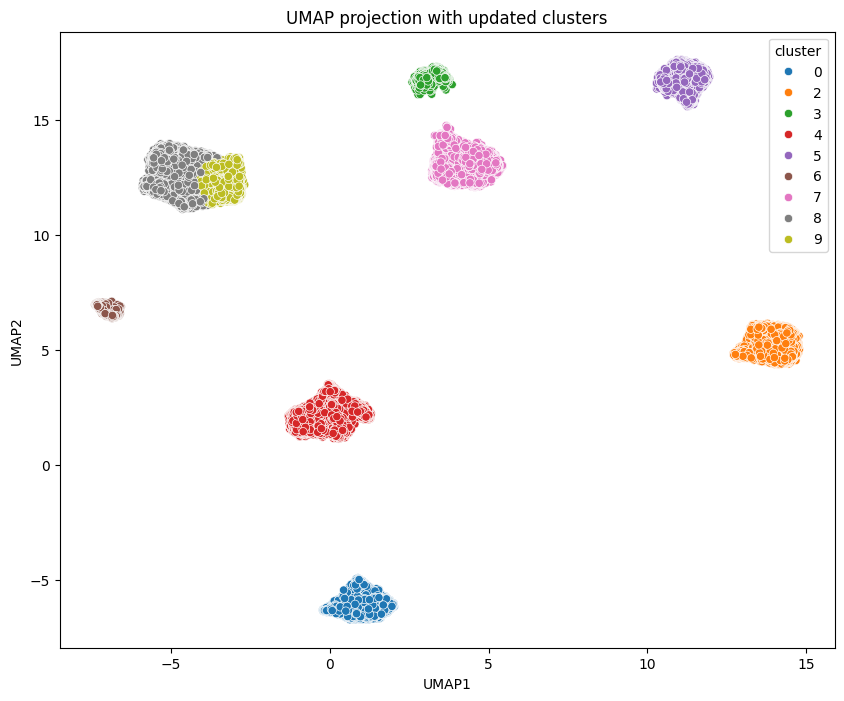

In [82]:
# apply hierarchical clustering on cluster 1
from sklearn.cluster import AgglomerativeClustering
cluster_1_data = final_umap_df[final_umap_df['cluster'] == 1]

ward = AgglomerativeClustering(n_clusters=2, linkage='ward')
ward_labels = ward.fit_predict(cluster_1_data[['UMAP1', 'UMAP2']])

cluster_1_data['subcluster'] = ward_labels

# Create a unique label for each subcluster within cluster 1
cluster_1_data['new_cluster'] = cluster_1_data['subcluster'].apply(lambda x: 8 + x)  # Assuming 10 and 11 are new labels

# Update the original DataFrame with the new cluster labels
final_umap_df.loc[cluster_1_data.index, 'cluster'] = cluster_1_data['new_cluster']

# Plot UMAP projection with updated clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='cluster', data=final_umap_df, palette='tab10')
plt.title('UMAP projection with updated clusters')
plt.show()